In [1]:
# Import the necessary libraries
import emcee

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pyazr import azure2
from natsort import natsorted
from brick.azr import AZR as brick

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

# Define the segment titles
titles = [r'(p,$\gamma$) Integrated', 
          r'(p,$\gamma$) Differential - 0 deg', r'(p,$\gamma$) Differential - 55 deg', r'(p,$\gamma$) Differential - 90 deg', 
          "(p,p) Differential - 84.3 deg", "(p,p) Differential - 114.5 deg", "(p,p) Differential - 144.1 deg"]

In [2]:
# We read the .azr file and set the external capture file to speed up the calculation
azr = azure2('12c_pg.azr')
theta0 = azr.params
ntheta = len(theta0)

# We'll read the data from the output file since it's already in the center-of-mass frame
y = azr.cross
yerr = azr.cross_err
ndata = sum( len(segment) for segment in y )

# Get the lables
brk = brick( "12c_pg.azr" )
params_labels = brk.config.labels
params_labels[-len(labels):] = labels

In [3]:
# Calculated squared residuals
def least_squares( mu, theta ):
    res = 0
    for i in range( len( mu ) ):
        idx = ntheta + i
        res += np.sum( pow( (mu[i] - y[i] * theta[idx]) / ( yerr[i] * theta[idx] ), 2 ) )
    return res

# Function to minimize
def func( theta, proc=0 ):
    mu = azr.calculate( theta[:ntheta], proc=proc )
    fcn = least_squares( mu, theta )
    return fcn

In [4]:
bucket = [ ]
for t, file in enumerate( natsorted(glob("results/ptemcee/*.h5")) ) :

    # Read the .h5 file
    backend = emcee.backends.HDFBackend(file)

    # Get the number of samples after burn in
    nb  = 3000
    lnp = backend.get_log_prob(discard=nb)
    ii  = np.where(np.median(lnp, axis=0)!=-np.inf)[0]

    # Get only the first chain
    samples = backend.get_chain(discard=nb)[:, ii, :]
    samples = samples.reshape((-1, samples.shape[-1]))

    bucket.append( samples )

# Fuse all buckets in one array
data_ptemcee = np.vstack( bucket )
ndim = samples.shape[1]

# Shuffle the data to get a better representation
np.random.shuffle( data_ptemcee )
data_ptemcee = data_ptemcee[:1000]

In [5]:
bucket = [ ]
for t, file in enumerate( natsorted(glob("results/emcee/*.h5")) ) :

    if( t > 15 ): continue

    # Read the .h5 file
    backend = emcee.backends.HDFBackend(file)

    # Get the number of samples after burn in
    nb  = 1000
    lnp = backend.get_log_prob(discard=nb)
    ii  = np.where(np.median(lnp, axis=0)!=-np.inf)[0]

    # Get only the first chain
    samples = backend.get_chain(discard=nb)[:, ii, :]
    samples = samples.reshape((-1, samples.shape[-1]))

    bucket.append( samples )

# Fuse all buckets in one array
data_emcee = np.vstack( bucket )
ndim = samples.shape[1]

# Shuffle the data to get a better representation
np.random.shuffle( data_emcee )
data_emcee = data_emcee[:1000]

In [6]:
data_norms = []
files = glob( "results/norms/samples.txt" )
for file in files:
    data_norms.append( np.loadtxt( file ) )
data_norms = np.concatenate( data_norms, axis=0 )[:1000]

In [7]:
data_initial = []
files = glob( "results/initial/samples.txt" )
for file in files:
    data_initial.append( np.loadtxt( file ) )
data_initial = np.concatenate( data_initial, axis=0 )[:1000]

In [8]:
minima = { "Frequentist - inital" : [], "Frequentist - norms" : [], 
           "Bayesian - emcee"     : [], "Bayesian - ptemcee"  : [] }

for theta in tqdm(data_initial):
    minima["Frequentist - inital"].append( func( theta ) )

for theta in tqdm(data_norms):
    minima["Frequentist - norms"].append( func( theta ) )

for theta in tqdm(data_emcee):
    minima["Bayesian - emcee"].append( func( theta ) )

for theta in tqdm(data_ptemcee):
    minima["Bayesian - ptemcee"].append( func( theta ) )

100%|██████████| 1000/1000 [00:17<00:00, 55.85it/s]


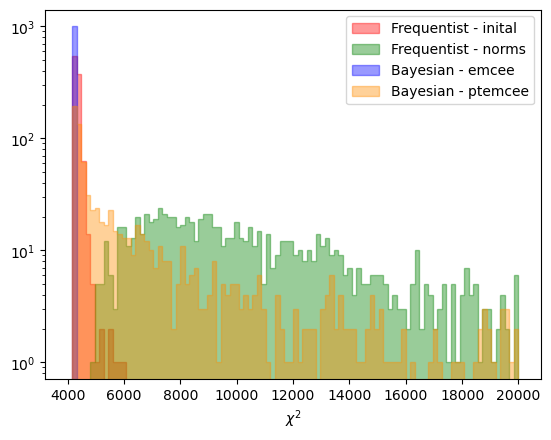

In [9]:
# Plot the chi^2 distribution
plt.hist( minima["Frequentist - inital"], bins=100, alpha=0.4, range=(4000,20000), label="Frequentist - inital", color="red",        histtype='step', fill=True )
plt.hist( minima["Frequentist - norms"],  bins=100, alpha=0.4, range=(4000,20000), label="Frequentist - norms",  color="green",      histtype='step', fill=True )
plt.hist( minima["Bayesian - emcee"],     bins=100, alpha=0.4, range=(4000,20000), label="Bayesian - emcee",     color="blue",       histtype='step', fill=True )
plt.hist( minima["Bayesian - ptemcee"],   bins=100, alpha=0.4, range=(4000,20000), label="Bayesian - ptemcee",   color="darkorange", histtype='step', fill=True )

plt.yscale( "log" )
plt.xlabel( '$\chi ^{2}$' )

plt.legend()

plt.savefig( "results/figures/minima.pdf" )
plt.show()

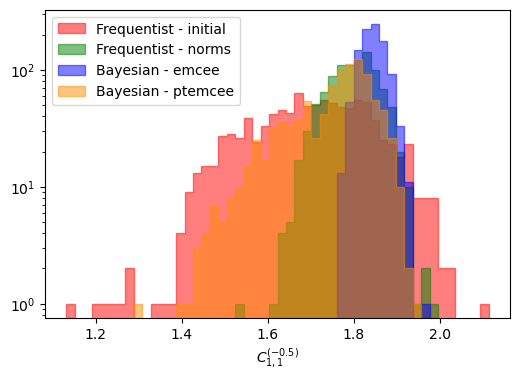

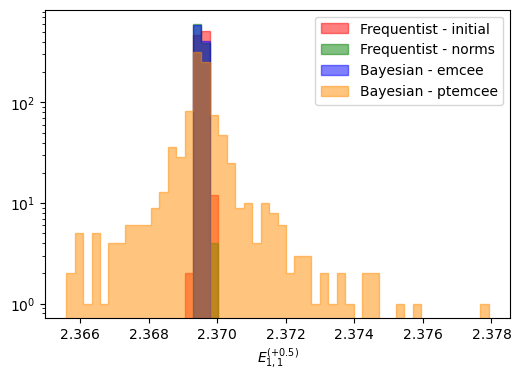

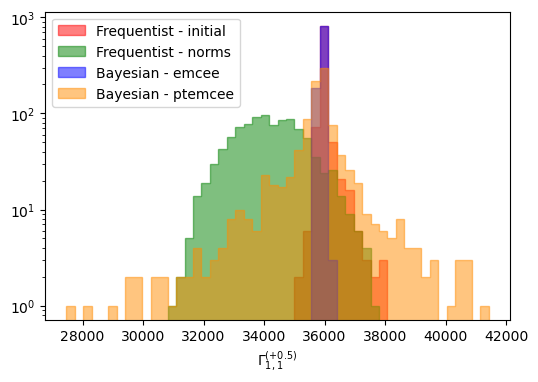

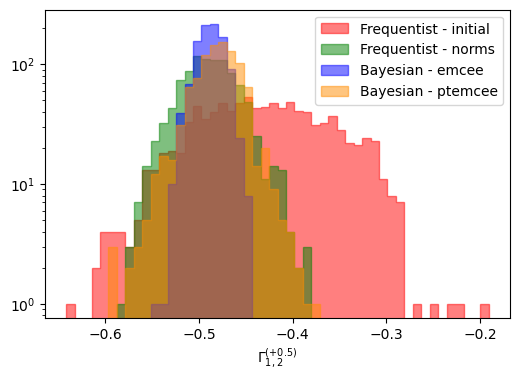

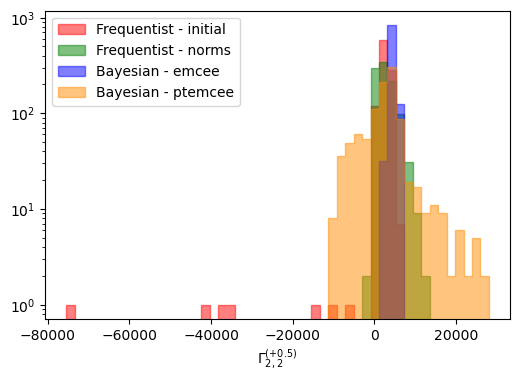

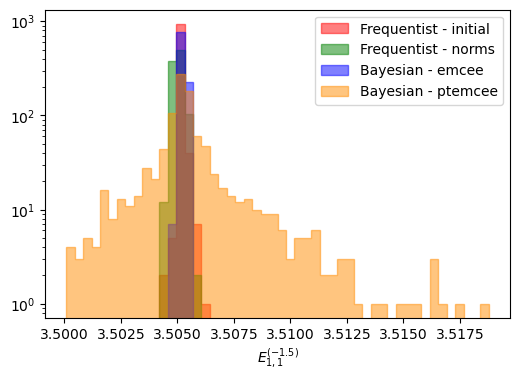

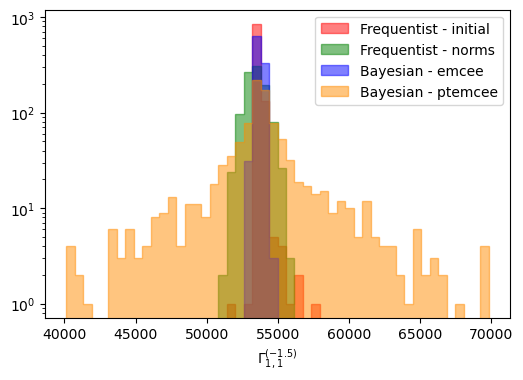

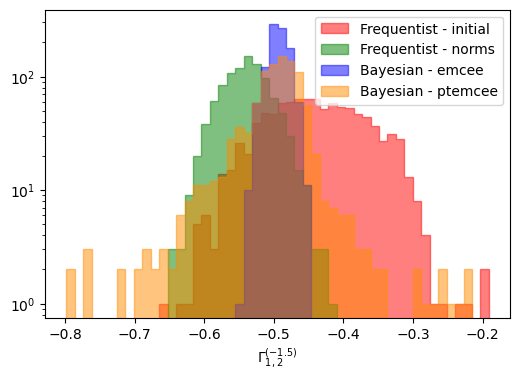

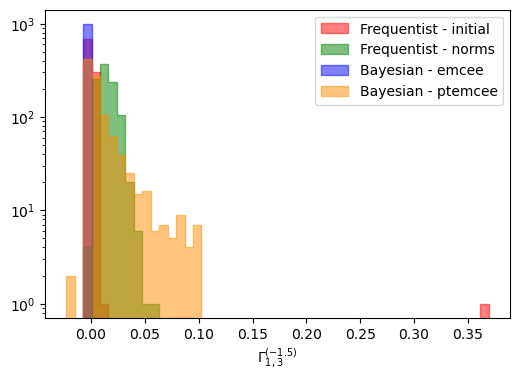

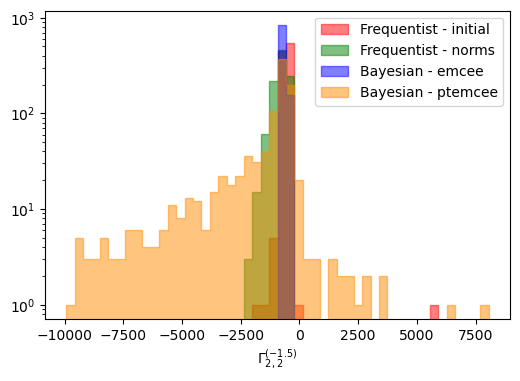

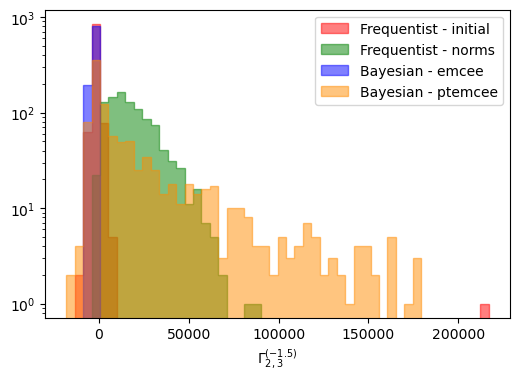

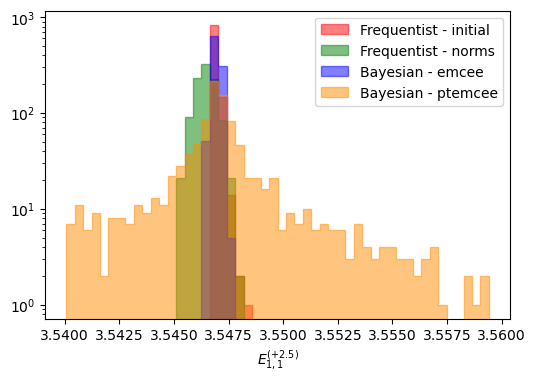

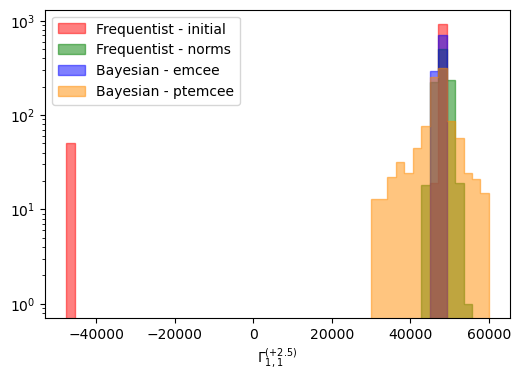

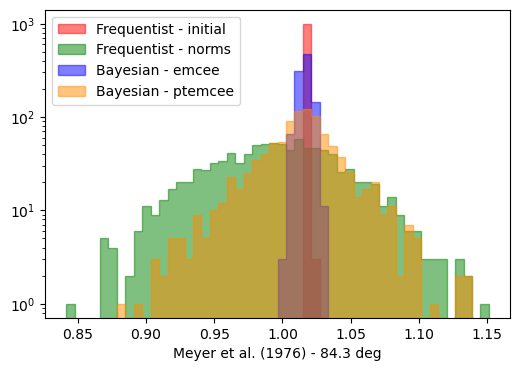

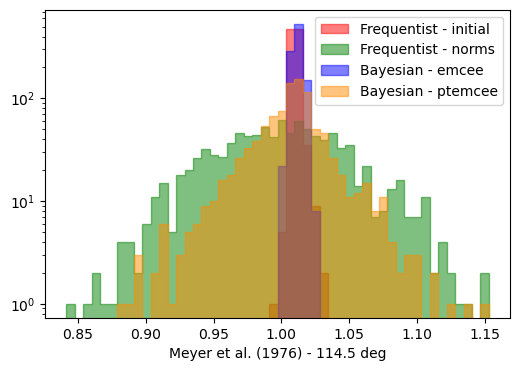

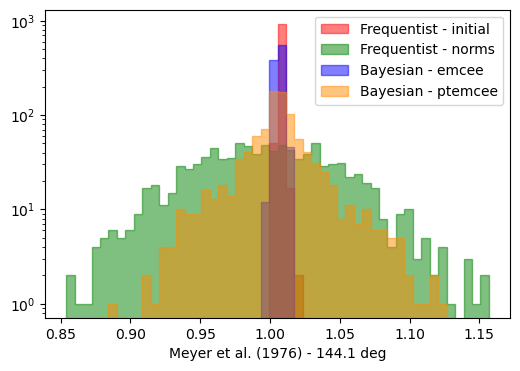

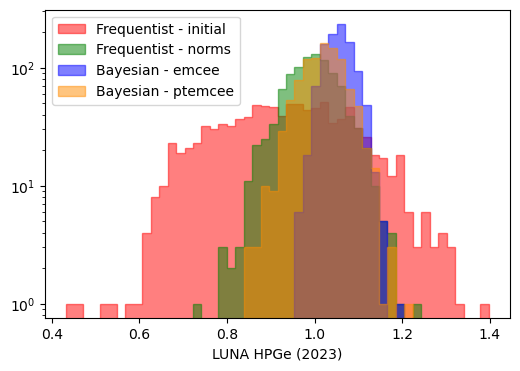

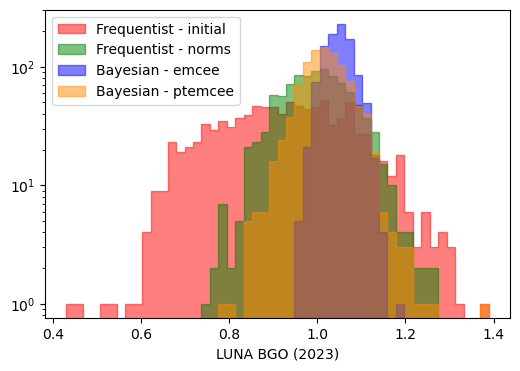

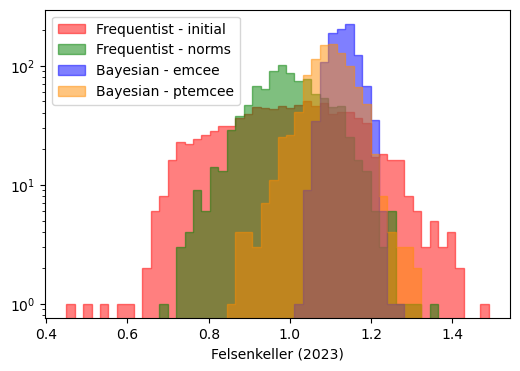

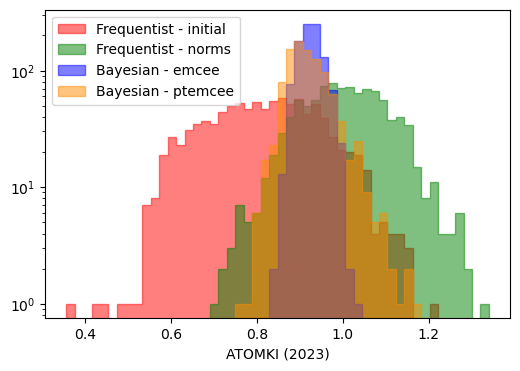

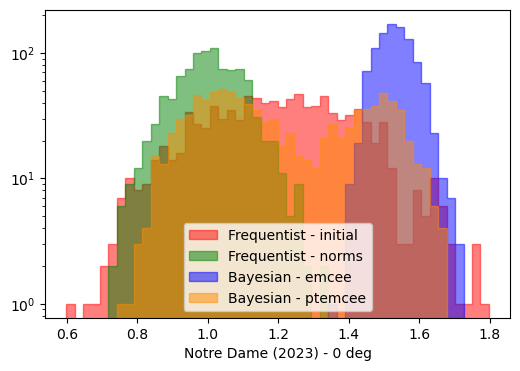

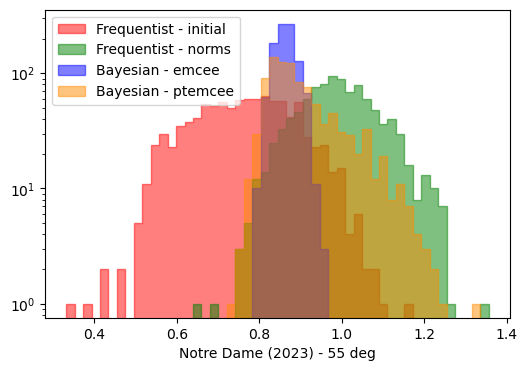

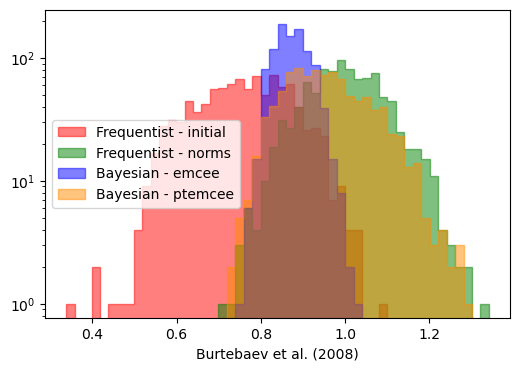

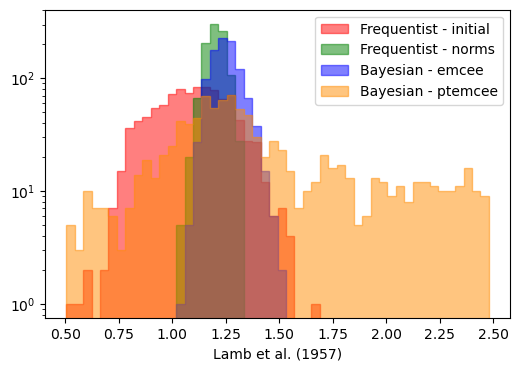

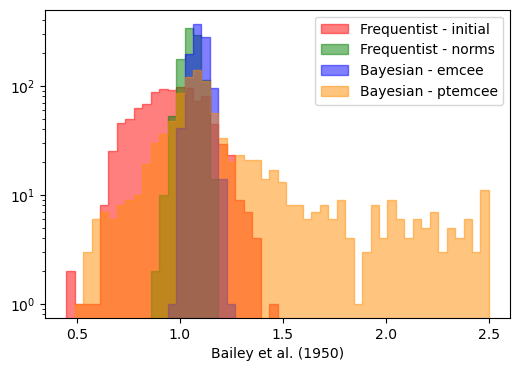

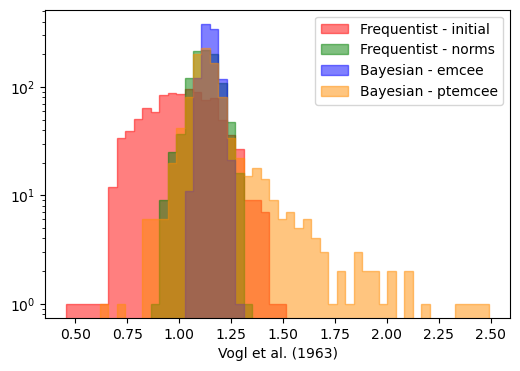

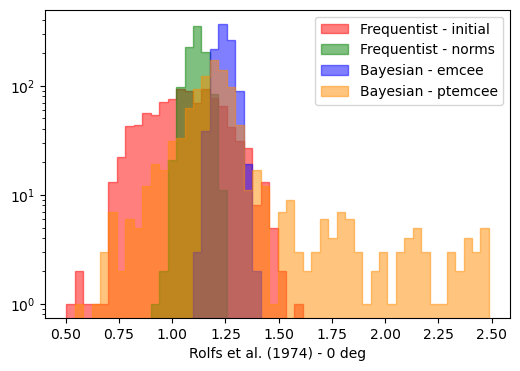

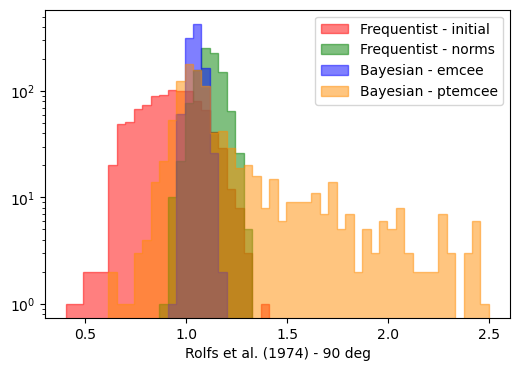

In [8]:
# Plot the histograms of the parameters
for i in range( data_initial.shape[1] ):
    fig, ax = plt.subplots( 1, 1, figsize=( 6, 4 ) )

    # Find minimum and maximum for the range
    min_ = min( data_initial[:,i].min(), data_norms[:,i].min(), data_emcee[:,i].min(), data_ptemcee[:,i].min() )
    max_ = max( data_initial[:,i].max(), data_norms[:,i].max(), data_emcee[:,i].max(), data_ptemcee[:,i].max() )
    range_ = (min_, max_)

    plt.hist( data_initial[:,i], bins=50, alpha=0.5, color="red",        range=range_, label="Frequentist - initial", histtype='step', fill=True )
    plt.hist( data_norms[:,i],   bins=50, alpha=0.5, color="green",      range=range_, label="Frequentist - norms",   histtype='step', fill=True )
    plt.hist( data_emcee[:,i],   bins=50, alpha=0.5, color="blue",       range=range_, label="Bayesian - emcee",      histtype='step', fill=True )
    plt.hist( data_ptemcee[:,i], bins=50, alpha=0.5, color="darkorange", range=range_, label="Bayesian - ptemcee",    histtype='step', fill=True )

    ax.set_xlabel( params_labels[i] )
    ax.set_yscale( "log" )
    ax.legend( )

    plt.savefig( "results/figures/parameter_{}.pdf".format( i ) )
    plt.show( )

In [12]:
# Read all the extrapolations
extrap_ptemcee = np.loadtxt("results/ptemcee/data/Segment 1.txt")
extrap_emcee = np.loadtxt("results/emcee/data/Segment 1.txt")

extrap_initial = np.loadtxt("results/initial/data/Segment 1.txt")
extrap_norms = np.loadtxt("results/norms/data/Segment 1.txt")

# Select the normalization
norm = extrap_ptemcee 

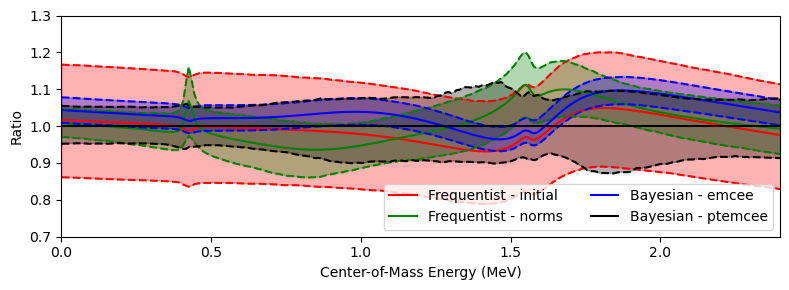

In [14]:
# Plot the extrapolation ratio
fig = plt.figure(figsize=(8, 3))

plt.plot( extrap_initial[:,0], extrap_initial[:,1] / extrap_ptemcee[:,1], color="red", label="Frequentist - initial" )
plt.fill_between( extrap_initial[:,0], (extrap_initial[:,1] - extrap_initial[:,3]) / norm[:,1], (extrap_initial[:,1] + extrap_initial[:,2]) / norm[:,1], alpha=0.3, color="red" )
plt.plot( extrap_initial[:,0], (extrap_initial[:,1] - extrap_initial[:,3]) / norm[:,1], color="red", ls="--" )
plt.plot( extrap_initial[:,0], (extrap_initial[:,1] + extrap_initial[:,2]) / norm[:,1], color="red", ls="--" )

plt.plot( extrap_norms[:,0], extrap_norms[:,1] / norm[:,1], color="green", label="Frequentist - norms" )
plt.fill_between( extrap_norms[:,0], (extrap_norms[:,1] - extrap_norms[:,3]) / norm[:,1], (extrap_norms[:,1] + extrap_norms[:,2]) / norm[:,1], alpha=0.3, color="green" )
plt.plot( extrap_norms[:,0], (extrap_norms[:,1] - extrap_norms[:,3])/norm[:,1], color="green", ls="--" )
plt.plot( extrap_norms[:,0], (extrap_norms[:,1] + extrap_norms[:,2])/norm[:,1], color="green", ls="--" )

plt.plot( extrap_emcee[:,0], extrap_emcee[:,1] / norm[:,1], color="blue", label="Bayesian - emcee" )
plt.fill_between( extrap_emcee[:,0], (extrap_emcee[:,1] - extrap_emcee[:,3]) / norm[:,1], (extrap_emcee[:,1] + extrap_emcee[:,2]) / norm[:,1], alpha=0.3, color="blue" )
plt.plot( extrap_emcee[:,0], (extrap_emcee[:,1] - extrap_emcee[:,3]) / norm[:,1], color="blue", ls="--" )
plt.plot( extrap_emcee[:,0], (extrap_emcee[:,1] + extrap_emcee[:,2]) / norm[:,1], color="blue", ls="--" )

plt.axhline( 1, color="black", label="Bayesian - ptemcee" )

plt.fill_between( extrap_ptemcee[:,0], (extrap_ptemcee[:,1] - extrap_ptemcee[:,3]) / norm[:,1], (extrap_ptemcee[:,1] + extrap_ptemcee[:,2]) / norm[:,1], alpha=0.3, color="black" )
plt.plot( extrap_ptemcee[:,0], (extrap_ptemcee[:,1] - extrap_ptemcee[:,3]) / norm[:,1], color="black", ls="--" )
plt.plot( extrap_ptemcee[:,0], (extrap_ptemcee[:,1] + extrap_ptemcee[:,2]) / norm[:,1], color="black", ls="--" )

plt.legend( ncol=2, loc="lower right" )

plt.xlim( 0, 2.4 )
plt.ylim( 0.7, 1.3 )

plt.ylabel( "Ratio" )
plt.xlabel( "Center-of-Mass Energy (MeV)" )

plt.tight_layout()

plt.savefig( "results/figures/extrapolation.pdf" )
plt.show() 